In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(most_recent)

('2017-08-23',)


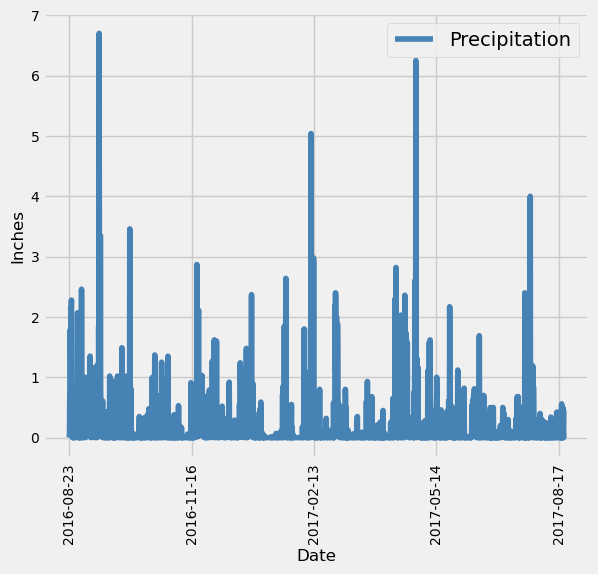

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
import datetime

date_string = most_recent[0]  # Extract the string from the row

# Calculate the date one year from the last date in data set.

date_object = datetime.datetime.strptime(date_string, '%Y-%m-%d').date()
one_year_ago = date_object - datetime.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df=pd.DataFrame(data)
df=df.dropna()
df=df.rename(columns={"prcp":"Precipitation"})
df
# Sort the dataframe by date
df=df.sort_values(by=['date'], ascending=True)
df=df.reset_index(drop=True)
df

# Use Pandas Plotting with Matplotlib to plot the data

df_new_index = df.set_index('date')
plot=df_new_index.plot(color='steelblue',figsize=(6,6),legend=True,grid=True)

plt.xticks(rotation='vertical',fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.xlabel("Date",size=12)
plt.ylabel("Inches",size=12)
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
num_stations = session.query(Station.station).count()
num_stations

9

In [19]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
num_stations = session.query(Measurement.station, func.count()).group_by(Measurement.station).order_by(func.count().desc()).all()
num_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = num_stations[0][0]

temps = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station==most_active).all()
temps

[(54.0, 85.0, 71.66378066378067)]

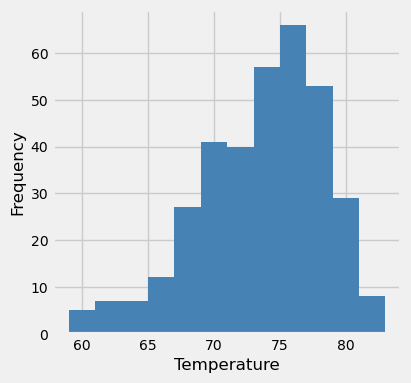

In [17]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
data = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station==most_active).filter(Measurement.date>=one_year_ago).all()

df=pd.DataFrame(data)
df=df.dropna()

hist = df['tobs'].hist(bins=12,figsize=(4,4), color='steelblue')

# Set y-axis label
hist.set_ylabel("Frequency",weight='light',size=12)
hist.set_xlabel("Temperature",weight='light',size=12)

plt.xticks([60,65,70,75,80],size=10)
plt.yticks(size=10)
plt.show()

# Close Session

In [18]:
# Close Session
session.close()